In [133]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [134]:
# Hyperparameters

size_of_batch = 16
hidden_size = 4
learning_rate = 0.0001
num_epochs = 200
num_stacked_layers = 2

# Functions

In [135]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #, (h0, c0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        

        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        

        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

def retrieve_dataframe(origin_filename: str):
    read_df = pd.read_csv(origin_filename)
    read_df.set_index('time', inplace=True)
    return read_df

# preparing for tensor dataset format

def numpy_to_tensor_split(ARRAY: np.array,
                          SCALER: MinMaxScaler, # must allready be fit
                          step: int):

    ARRAY = SCALER.fit_transform(ARRAY)
    
    input = ARRAY[step:,1:]
    if step == 0:
        target = ARRAY[:,0]
    else:
        target = ARRAY[:-step,0]
    
    split_index = int(len(input) * .70)
    
    input_train = input[:split_index]
    input_test = input[split_index:]
    
    target_train = target[:split_index]
    target_test = target[split_index:]
    
    lookback = 7
    
    # match batch dimension
    input_train = input_train.reshape((-1, lookback, 1))
    input_test = input_test.reshape((-1, lookback, 1))
    
    target_train = target_train.reshape((-1,1))
    target_test = target_test.reshape((-1,1))
    
    # float tensor converstion
    input_train = torch.tensor(input_train).float()
    input_test = torch.tensor(input_test).float()
    
    target_train = torch.tensor(target_train).float()
    target_test = torch.tensor(target_test).float()

    return input_train, target_train, input_test, target_test

In [139]:
def train_one_epoch(MODEL: nn.Module,
                   OPTIMIZER: torch.optim,
                   LOSS: nn.MSELoss,
                   LOADER: DataLoader):
    MODEL.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    train_epoch_loss = 0.0
    
    for batch_index, batch in enumerate(LOADER):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = MODEL(x_batch)
        batch_loss = LOSS(output, y_batch)
        running_loss += batch_loss.item()
        train_epoch_loss += batch_loss.item()
        
        OPTIMIZER.zero_grad()
        batch_loss.backward()
        OPTIMIZER.step()

        if batch_index % 100 == 0:  # print every 100 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:1.10f}'.format(batch_index,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    return train_epoch_loss

def validate_one_epoch(MODEL: nn.Module,
                       LOSS: nn.MSELoss,
                       LOADER: DataLoader):
    MODEL.train(False)
    running_loss = 0.0
    test_epoch_loss = 0.
    
    for batch_index, batch in enumerate(LOADER):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = MODEL(x_batch)
            batch_loss = LOSS(output, y_batch)
            running_loss += batch_loss.item()
            test_epoch_loss += batch_loss.item()

    avg_loss_across_batches = running_loss / len(LOADER)
    
    print('Val Loss: {0:.10f}'.format(avg_loss_across_batches))
    print('***************************************************')

    return test_epoch_loss

# Dataset Construction

In [136]:
device = 'cudo:0' if torch.cuda.is_available() else 'cpu'

df = retrieve_dataframe('./data/formatted/final_file.csv')
scaler = MinMaxScaler(feature_range=(-1, 1))


In [137]:
# regular data set construction
X_train, y_train, X_test, y_test = numpy_to_tensor_split(ARRAY=df.to_numpy(),
                                                         SCALER=scaler,
                                                         step=0)
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=size_of_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=size_of_batch, shuffle=False)

In [14]:
# Shifiting the dataset for the step ahead lstm
X_train_1, y_train_1, X_test_1, y_test_1 = numpy_to_tensor_split(ARRAY=df.to_numpy(),
                                                         SCALER=scaler,
                                                         step=1)
train_dataset_1 = TimeSeriesDataset(X_train_1, y_train_1)
test_dataset_1 = TimeSeriesDataset(X_test_1, y_test_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=size_of_batch, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=size_of_batch, shuffle=False)

In [15]:
# Shifiting the dataset for the two step ahead lstm
X_train_2, y_train_2, X_test_2, y_test_2 = numpy_to_tensor_split(ARRAY=df.to_numpy(),
                                                         SCALER=scaler,
                                                         step=2)
train_dataset_2 = TimeSeriesDataset(X_train_2, y_train_2)
test_dataset_2 = TimeSeriesDataset(X_test_2, y_test_2)

train_loader_2 = DataLoader(train_dataset_2, batch_size=size_of_batch, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=size_of_batch, shuffle=False)

In [16]:
# Shifiting the dataset for the three step ahead lstm
X_train_3, y_train_3, X_test_3, y_test_3 = numpy_to_tensor_split(ARRAY=df.to_numpy(),
                                                         SCALER=scaler,
                                                         step=3)
train_dataset_3 = TimeSeriesDataset(X_train_3, y_train_3)
test_dataset_3 = TimeSeriesDataset(X_test_3, y_test_3)

train_loader_3 = DataLoader(train_dataset_3, batch_size=size_of_batch, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=size_of_batch, shuffle=False)

In [17]:
# Shifiting the dataset for the three step ahead lstm
X_train_4, y_train_4, X_test_4, y_test_4 = numpy_to_tensor_split(ARRAY=df.to_numpy(),
                                                         SCALER=scaler,
                                                         step=4)
train_dataset_4 = TimeSeriesDataset(X_train_4, y_train_4)
test_dataset_4 = TimeSeriesDataset(X_test_4, y_test_4)

train_loader_4 = DataLoader(train_dataset_4, batch_size=size_of_batch, shuffle=True)
test_loader_4 = DataLoader(test_dataset_4, batch_size=size_of_batch, shuffle=False)

In [138]:
num_batches = 0

for i, _ in enumerate(train_loader):
    num_batches = i
    
print(f'Number of batches: {num_batches}')

Number of batches: 1286


# LSTM Training

In [ ]:
# Regular LSTM Model
model = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

train_loss = []
test_loss = []

for epoch in range(num_epochs):
    train_loss.append(train_one_epoch(MODEL=model,
                                      OPTIMIZER=optimizer,
                                      LOSS=loss_function,
                                      LOADER=train_loader))
    test_loss.append(validate_one_epoch(MODEL=model,
                                        LOSS=loss_function,
                                        LOADER=train_loader))

In [ ]:
# starting at Epoch 2 instead of 2 to see the learning curve better
plt.plot(train_loss[1:], label="Training Set")
plt.plot(test_loss[1:], label="Testing Set")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss.png')

In [ ]:
# Train the Model to predict one step ahead
model_1 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_1.to(device)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
loss_function_1 = nn.MSELoss()

train_loss_1 = []
test_loss_1 = []

for epoch in range(num_epochs):
    train_loss_1.append(train_one_epoch(MODEL=model_1,
                                      OPTIMIZER=optimizer_1,
                                      LOSS=loss_function_1,
                                      LOADER=train_loader_1))
    test_loss_1.append(validate_one_epoch(MODEL=model_1,
                                        LOSS=loss_function_1,
                                        LOADER=train_loader_1))

Epoch: 1
Batch 0, Loss: 0.0607322454
Batch 100, Loss: 4.6072827116
Batch 200, Loss: 4.3260919258
Batch 300, Loss: 4.0899053246
Batch 400, Loss: 3.7051700741
Batch 500, Loss: 3.6071251512
Batch 600, Loss: 3.3410297632
Batch 700, Loss: 2.9027740419
Batch 800, Loss: 2.6767864883
Batch 900, Loss: 2.3348119035
Batch 1000, Loss: 1.8309732296
Batch 1100, Loss: 1.4153267927
Batch 1200, Loss: 0.9754732113
Val Loss: 0.0562524581
***************************************************
Epoch: 2
Batch 0, Loss: 0.0069923609
Batch 100, Loss: 0.4376101045
Batch 200, Loss: 0.2814318003
Batch 300, Loss: 0.2235028970
Batch 400, Loss: 0.1836335834
Batch 500, Loss: 0.1254193550
Batch 600, Loss: 0.1168782042
Batch 700, Loss: 0.1271572353
Batch 800, Loss: 0.1390194235
Batch 900, Loss: 0.1036679096
Batch 1000, Loss: 0.1000045642
Batch 1100, Loss: 0.1122061314
Batch 1200, Loss: 0.1430113127
Val Loss: 0.0103558896
***************************************************
Epoch: 3
Batch 0, Loss: 0.0007083916
Batch 100, Lo

In [ ]:
# starting at Epoch 2 instead of 2 to see the learning curve better
plt.plot(train_loss_1[1:], label="Training Set")
plt.plot(test_loss_1[1:], label="Testing Set")
plt.title("LSTM+1 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss_step_1.png')

In [ ]:
# Train the Model to predict two steps ahead
model_2 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_2.to(device)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
loss_function_2 = nn.MSELoss()

train_loss_2 = []
test_loss_2 = []

for epoch in range(num_epochs):
    train_loss_2.append(train_one_epoch(MODEL=model_2,
                                      OPTIMIZER=optimizer_2,
                                      LOSS=loss_function_2,
                                      LOADER=train_loader_2))
    test_loss_2.append(validate_one_epoch(MODEL=model_2,
                                        LOSS=loss_function_2,
                                        LOADER=train_loader_2))

In [ ]:
plt.plot(train_loss_2[1:], label="Training Set")
plt.plot(test_loss_2[1:], label="Testing Set")
plt.title("LSTM+2 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss_step_2.png')

In [ ]:
# Train the Model to predict one step ahead
model_3 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_3.to(device)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=learning_rate)
loss_function_3 = nn.MSELoss()

train_loss_3 = []
test_loss_3 = []

for epoch in range(num_epochs):
    train_loss_3.append(train_one_epoch(MODEL=model_3,
                                      OPTIMIZER=optimizer_3,
                                      LOSS=loss_function_3,
                                      LOADER=train_loader_3))
    test_loss_3.append(validate_one_epoch(MODEL=model_3,
                                        LOSS=loss_function_3,
                                        LOADER=train_loader_3))

In [ ]:
plt.plot(train_loss_3[1:], label="Training Set")
plt.plot(test_loss_3[1:], label="Testing Set")
plt.title("LSTM+3 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss_step_3.png')

In [ ]:
# Train the Model to predict one step ahead
model_4 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_4.to(device)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=learning_rate)
loss_function_4 = nn.MSELoss()

train_loss_4 = []
test_loss_4 = []

for epoch in range(num_epochs):
    train_loss_4.append(train_one_epoch(MODEL=model_4,
                                      OPTIMIZER=optimizer_4,
                                      LOSS=loss_function_4,
                                      LOADER=train_loader_4))
    test_loss_4.append(validate_one_epoch(MODEL=model_4,
                                        LOSS=loss_function_4,
                                        LOADER=train_loader_4))

In [ ]:
plt.plot(train_loss_4[1:], label="Training Set")
plt.plot(test_loss_4[1:], label="Testing Set")
plt.title("LSTM+4 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss_step_4.png')

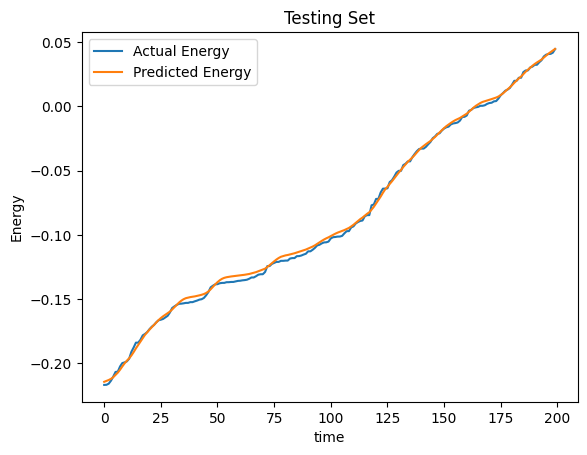

In [20]:
with torch.no_grad():
    predicted_1 = model_1(X_test_1.to(device)).to('cpu').numpy()

plt.plot(y_test_1[200:400], label='Actual Energy')
plt.plot(predicted_1[200:400], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

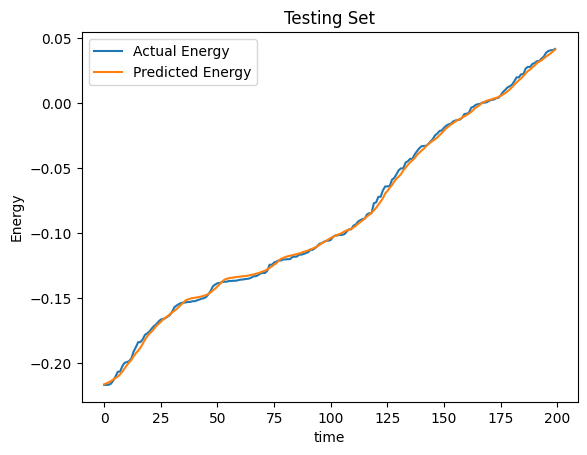

In [21]:
with torch.no_grad():
    predicted_2 = model_2(X_test_2.to(device)).to('cpu').numpy()

plt.plot(y_test_2[200:400], label='Actual Energy')
plt.plot(predicted_2[200:400], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

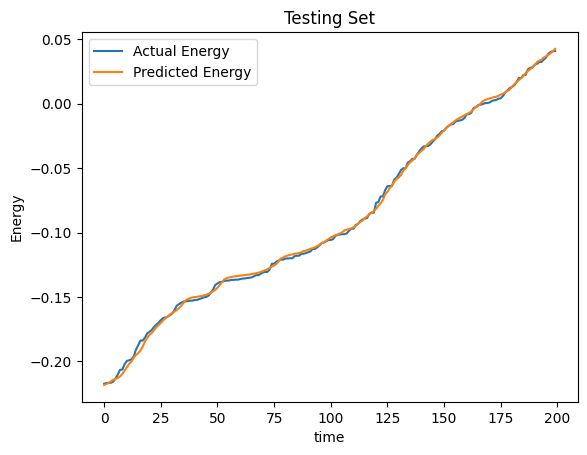

In [22]:
with torch.no_grad():
    predicted_3 = model_3(X_test_3.to(device)).to('cpu').numpy()

plt.plot(y_test_3[200:400], label='Actual Energy')
plt.plot(predicted_3[200:400], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

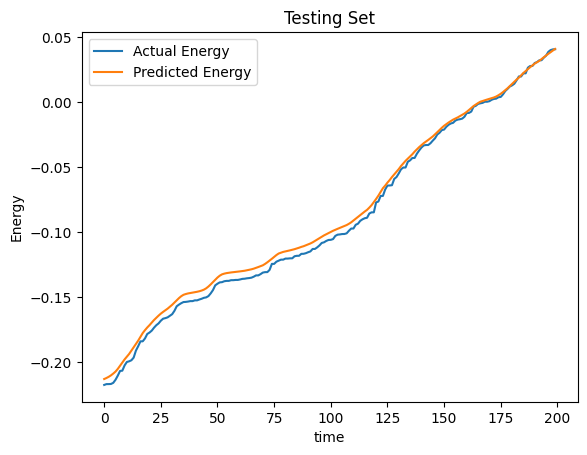

In [23]:
with torch.no_grad():
    predicted_4 = model_4(X_test_4.to(device)).to('cpu').numpy()

plt.plot(y_test_4[200:400], label='Actual Energy')
plt.plot(predicted_4[200:400], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

# RNN Training

In [ ]:
# RNN model
rnn_model = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model.to(device)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
rnn_loss_function = nn.MSELoss()

rnn_train_loss = []
rnn_test_loss = []

for epoch in range(num_epochs):
    rnn_train_loss.append(train_one_epoch(MODEL=rnn_model,
                                      OPTIMIZER=rnn_optimizer,
                                      LOSS=rnn_loss_function,
                                      LOADER=train_loader))
    rnn_test_loss.append(validate_one_epoch(MODEL=rnn_model,
                                        LOSS=rnn_loss_function,
                                        LOADER=train_loader))

In [ ]:
plt.plot(rnn_train_loss[1:], label="Training Set")
plt.plot(rnn_test_loss[1:], label="Testing Set")
plt.title("RNN Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./RNN_loss.png')

In [ ]:
# RNN model 1 time step further
rnn_model_1 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_1.to(device)
rnn_optimizer_1 = torch.optim.Adam(rnn_model_1.parameters(), lr=learning_rate)
rnn_loss_function_1 = nn.MSELoss()

rnn_train_loss_1 = []
rnn_test_loss_1 = []

for epoch in range(num_epochs):
    rnn_train_loss_1.append(train_one_epoch(MODEL=rnn_model_1,
                                      OPTIMIZER=rnn_optimizer_1,
                                      LOSS=rnn_loss_function_1,
                                      LOADER=train_loader_1))
    rnn_test_loss_1.append(validate_one_epoch(MODEL=rnn_model_1,
                                        LOSS=rnn_loss_function_1,
                                        LOADER=train_loader_1))

In [ ]:
plt.plot(rnn_train_loss_1[1:], label="Training Set")
plt.plot(rnn_test_loss_1[1:], label="Testing Set")
plt.title("RNN+1 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./RNN_loss_step_1.png')

In [ ]:
# RNN model 2 time step further
rnn_model_2 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_2.to(device)
rnn_optimizer_2 = torch.optim.Adam(rnn_model_2.parameters(), lr=learning_rate)
rnn_loss_function_2 = nn.MSELoss()

rnn_train_loss_2 = []
rnn_test_loss_2 = []

for epoch in range(num_epochs):
    rnn_train_loss_2.append(train_one_epoch(MODEL=rnn_model_2,
                                      OPTIMIZER=rnn_optimizer_2,
                                      LOSS=rnn_loss_function_2,
                                      LOADER=train_loader_2))
    rnn_test_loss_2.append(validate_one_epoch(MODEL=rnn_model_2,
                                        LOSS=rnn_loss_function_2,
                                        LOADER=train_loader_2))

In [ ]:
plt.plot(rnn_train_loss_2[1:], label="Training Set")
plt.plot(rnn_test_loss_2[1:], label="Testing Set")
plt.title("RNN+2 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./RNN_loss_step_2.png')

In [ ]:
# RNN model 3 time step further
rnn_model_3 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_3.to(device)
rnn_optimizer_3 = torch.optim.Adam(rnn_model_3.parameters(), lr=learning_rate)
rnn_loss_function_3 = nn.MSELoss()

rnn_train_loss_3 = []
rnn_test_loss_3 = []

for epoch in range(num_epochs):
    rnn_train_loss_3.append(train_one_epoch(MODEL=rnn_model_3,
                                      OPTIMIZER=rnn_optimizer_3,
                                      LOSS=rnn_loss_function_3,
                                      LOADER=train_loader_3))
    rnn_test_loss_3.append(validate_one_epoch(MODEL=rnn_model_3,
                                        LOSS=rnn_loss_function_3,
                                        LOADER=train_loader_3))

In [ ]:
plt.plot(rnn_train_loss_3[1:], label="Training Set")
plt.plot(rnn_test_loss_3[1:], label="Testing Set")
plt.title("RNN+3 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./RNN_loss_step_3.png')

In [ ]:
# RNN model 4 time step further
rnn_model_4 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_4.to(device)
rnn_optimizer_4 = torch.optim.Adam(rnn_model_4.parameters(), lr=learning_rate)
rnn_loss_function_4 = nn.MSELoss()

rnn_train_loss_4 = []
rnn_test_loss_4 = []

for epoch in range(num_epochs):
    rnn_train_loss_4.append(train_one_epoch(MODEL=rnn_model_4,
                                      OPTIMIZER=rnn_optimizer_4,
                                      LOSS=rnn_loss_function_4,
                                      LOADER=train_loader_4))
    rnn_test_loss_4.append(validate_one_epoch(MODEL=rnn_model_4,
                                        LOSS=rnn_loss_function_4,
                                        LOADER=train_loader_4))

In [ ]:
plt.plot(rnn_train_loss_4[1:], label="Training Set")
plt.plot(rnn_test_loss_4[1:], label="Testing Set")
plt.title("RNN+4 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./RNN_loss_step_4.png')

# GRU Training

In [ ]:
# GRU model 1 time step further
gru_model = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model.to(device)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
gru_loss_function = nn.MSELoss()

gru_train_loss = []
gru_test_loss = []

for epoch in range(num_epochs):
    gru_train_loss.append(train_one_epoch(MODEL=gru_model,
                                      OPTIMIZER=gru_optimizer,
                                      LOSS=gru_loss_function,
                                      LOADER=train_loader))
    gru_test_loss.append(validate_one_epoch(MODEL=gru_model,
                                        LOSS=gru_loss_function,
                                        LOADER=train_loader))

In [ ]:
plt.plot(gru_train_loss[1:], label="Training Set")
plt.plot(gru_test_loss[1:], label="Testing Set")
plt.title("GRU Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./GRU_loss.png')

In [ ]:
# GRU model 1 time step further
gru_model_1 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_1.to(device)
gru_optimizer_1 = torch.optim.Adam(gru_model_1.parameters(), lr=learning_rate)
gru_loss_function_1 = nn.MSELoss()

gru_train_loss_1 = []
gru_test_loss_1 = []

for epoch in range(num_epochs):
    gru_train_loss_1.append(train_one_epoch(MODEL=gru_model_1,
                                      OPTIMIZER=gru_optimizer_1,
                                      LOSS=gru_loss_function_1,
                                      LOADER=train_loader_1))
    gru_test_loss_1.append(validate_one_epoch(MODEL=gru_model_1,
                                        LOSS=gru_loss_function_1,
                                        LOADER=train_loader_1))

In [ ]:
plt.plot(gru_train_loss_1[1:], label="Training Set")
plt.plot(gru_test_loss_1[1:], label="Testing Set")
plt.title("GRU+1 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./GRU_loss_step_1.png')

In [ ]:
# GRU model 2 time step further
gru_model_2 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_2.to(device)
gru_optimizer_2 = torch.optim.Adam(gru_model_2.parameters(), lr=learning_rate)
gru_loss_function_2 = nn.MSELoss()

gru_train_loss_2 = []
gru_test_loss_2 = []

for epoch in range(num_epochs):
    gru_train_loss_2.append(train_one_epoch(MODEL=gru_model_2,
                                      OPTIMIZER=gru_optimizer_2,
                                      LOSS=gru_loss_function_2,
                                      LOADER=train_loader_2))
    gru_test_loss_2.append(validate_one_epoch(MODEL=gru_model_2,
                                        LOSS=gru_loss_function_2,
                                        LOADER=train_loader_2))

In [ ]:
plt.plot(gru_train_loss_2[1:], label="Training Set")
plt.plot(gru_test_loss_2[1:], label="Testing Set")
plt.title("GRU+2 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./GRU_loss_step_2.png')

In [ ]:
# GRU model 3 time step further
gru_model_3 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_3.to(device)
gru_optimizer_3 = torch.optim.Adam(gru_model_3.parameters(), lr=learning_rate)
gru_loss_function_3 = nn.MSELoss()

gru_train_loss_3 = []
gru_test_loss_3 = []

for epoch in range(num_epochs):
    gru_train_loss_3.append(train_one_epoch(MODEL=gru_model_3,
                                      OPTIMIZER=gru_optimizer_3,
                                      LOSS=gru_loss_function_3,
                                      LOADER=train_loader_3))
    gru_test_loss_3.append(validate_one_epoch(MODEL=gru_model_3,
                                        LOSS=gru_loss_function_3,
                                        LOADER=train_loader_3))

In [ ]:
plt.plot(gru_train_loss_3[1:], label="Training Set")
plt.plot(gru_test_loss_3[1:], label="Testing Set")
plt.title("GRU+3 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./GRU_loss_step_3.png')

In [ ]:
# GRU model 4 time step further
gru_model_4 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_4.to(device)
gru_optimizer_4 = torch.optim.Adam(gru_model_4.parameters(), lr=learning_rate)
gru_loss_function_4 = nn.MSELoss()

gru_train_loss_4 = []
gru_test_loss_4 = []

for epoch in range(num_epochs):
    gru_train_loss_4.append(train_one_epoch(MODEL=gru_model_4,
                                      OPTIMIZER=gru_optimizer_4,
                                      LOSS=gru_loss_function_4,
                                      LOADER=train_loader_4))
    gru_test_loss_4.append(validate_one_epoch(MODEL=gru_model_4,
                                        LOSS=gru_loss_function_4,
                                        LOADER=train_loader_4))

In [ ]:
plt.plot(gru_train_loss_4[1:], label="Training Set")
plt.plot(gru_test_loss_4[1:], label="Testing Set")
plt.title("GRU+4 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./GRU_loss_step_4.png')

# LSTM Loading

In [7]:
model = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
checkpoint = torch.load('./model_savepoint/LSTM')

model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [9]:
model_1 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model.to(device)
checkpoint = torch.load('./model_savepoint/LSTM_1')

model_1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
model_2 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_2.to(device)
checkpoint = torch.load('./model_savepoint/LSTM_2')

model_2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
model_3 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_3.to(device)
checkpoint = torch.load('./model_savepoint/LSTM_3')

model_3.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model_4 = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
model_4.to(device)
checkpoint = torch.load('./model_savepoint/LSTM_4')

model_4.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
plt.plot(train_loss[1:] label="Training Set")
plt.plot(test_loss[1:] label="Testing Set")
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
# plt.savefig('./LSTM_loss.png')

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Energy')
plt.plot(predicted, label='Predicted Energy')
plt.title("Training Set")
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

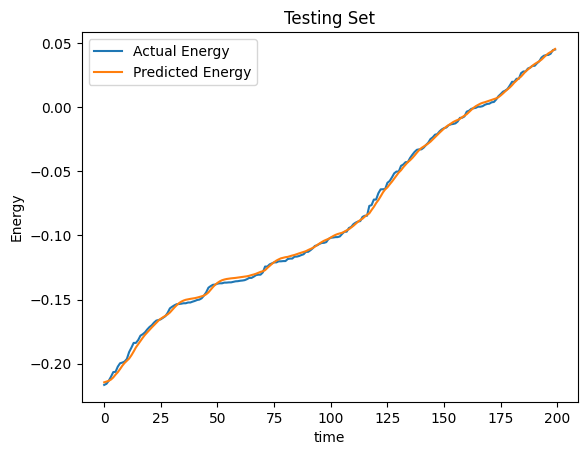

In [19]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test[200:400], label='Actual Energy')
plt.plot(predicted[200:400], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

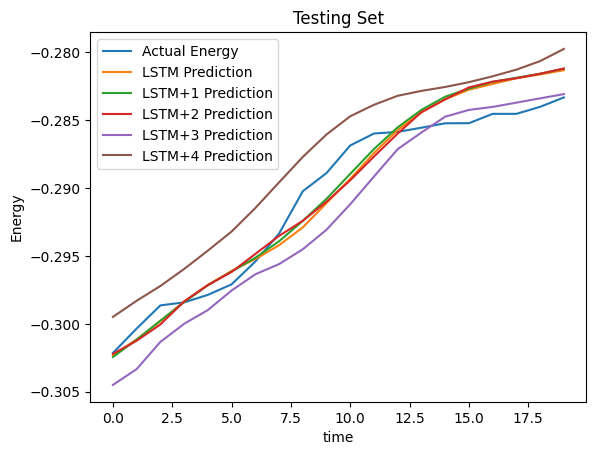

In [24]:
plt.plot(y_test[100:120], label='Actual Energy')
plt.plot(predicted[100:120], label='LSTM Prediction')
plt.plot(predicted_1[101:121], label='LSTM+1 Prediction')
plt.plot(predicted_2[102:122], label='LSTM+2 Prediction')
plt.plot(predicted_3[103:123], label='LSTM+3 Prediction')
plt.plot(predicted_4[104:124], label='LSTM+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
plt.plot(y_test_1[100:200], label='Actual Energy')
plt.plot(predicted_1[100:200], label='Predicted Energy')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
predicted[100:120].flatten()

In [ ]:
future_prediction = np.concatenate((predicted[100:120].flatten(),predicted_1[121],predicted_2[122],predicted_3[123]))

In [ ]:

plt.plot(y_test[100:120], label='Actual Energy')
plt.plot(future_prediction, label='LSTM Future Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

# RNN Loading

In [33]:
rnn_model = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model.to(device)
checkpoint = torch.load('./model_savepoint/RNN_')

rnn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [26]:
rnn_model_1 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_1.to(device)
checkpoint = torch.load('./model_savepoint/RNN_1')

rnn_model_1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [27]:
rnn_model_2 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_2.to(device)
checkpoint = torch.load('./model_savepoint/RNN_2')

rnn_model_2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
rnn_model_3 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_3.to(device)
checkpoint = torch.load('./model_savepoint/RNN_3')

rnn_model_3.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
rnn_model_4 = RNN(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
rnn_model_4.to(device)
checkpoint = torch.load('./model_savepoint/RNN_4')

rnn_model_4.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [35]:
with torch.no_grad():
    rnn_predicted = rnn_model(X_test.to(device)).to('cpu').numpy()
    rnn_predicted_1 = rnn_model_1(X_test_1.to(device)).to('cpu').numpy()
    rnn_predicted_2 = rnn_model_2(X_test_2.to(device)).to('cpu').numpy()
    rnn_predicted_3 = rnn_model_3(X_test_3.to(device)).to('cpu').numpy()
    rnn_predicted_4 = rnn_model_4(X_test_4.to(device)).to('cpu').numpy()

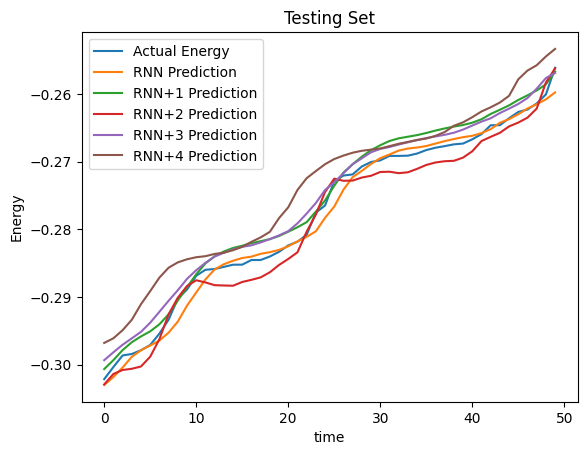

In [45]:
plt.plot(y_test[100:150], label='Actual Energy')
plt.plot(rnn_predicted[100:150], label='RNN Prediction')
plt.plot(rnn_predicted_1[101:151], label='RNN+1 Prediction')
plt.plot(rnn_predicted_2[102:152], label='RNN+2 Prediction')
plt.plot(rnn_predicted_3[103:153], label='RNN+3 Prediction')
plt.plot(rnn_predicted_4[104:154], label='RNN+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

# GRU Loading

In [37]:
gru_model = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model.to(device)
checkpoint = torch.load('./model_savepoint/GRU')

gru_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [43]:
gru_model_1 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_1.to(device)
checkpoint = torch.load('./model_savepoint/GRU_1')

gru_model_1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [39]:
gru_model_2 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_2.to(device)
checkpoint = torch.load('./model_savepoint/GRU_2')

gru_model_2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [40]:
gru_model_3 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_3.to(device)
checkpoint = torch.load('./model_savepoint/GRU_3')

gru_model_3.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [42]:
gru_model_4 = GRU(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers)
gru_model_4.to(device)
checkpoint = torch.load('./model_savepoint/GRU_4')

gru_model_4.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [44]:
with torch.no_grad():
    gru_predicted = gru_model(X_test.to(device)).to('cpu').numpy()
    gru_predicted_1 = gru_model_1(X_test_1.to(device)).to('cpu').numpy()
    gru_predicted_2 = gru_model_2(X_test_2.to(device)).to('cpu').numpy()
    gru_predicted_3 = gru_model_3(X_test_3.to(device)).to('cpu').numpy()
    gru_predicted_4 = gru_model_4(X_test_4.to(device)).to('cpu').numpy()

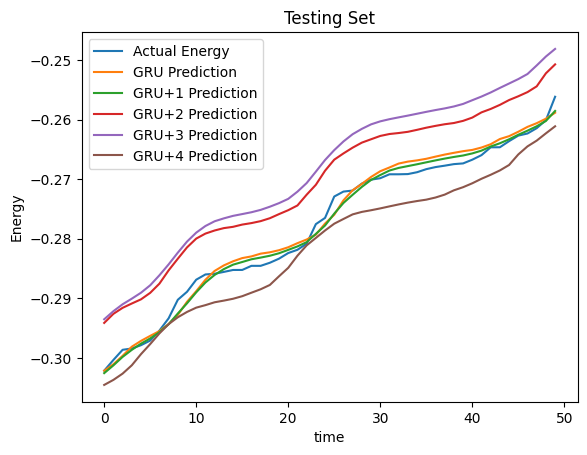

In [49]:
plt.plot(y_test[100:150], label='Actual Energy')
plt.plot(gru_predicted[100:150], label='GRU Prediction')
plt.plot(gru_predicted_1[101:151], label='GRU+1 Prediction')
plt.plot(gru_predicted_2[102:152], label='GRU+2 Prediction')
plt.plot(gru_predicted_3[103:153], label='GRU+3 Prediction')
plt.plot(gru_predicted_4[104:154], label='GRU+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

# Box Plot

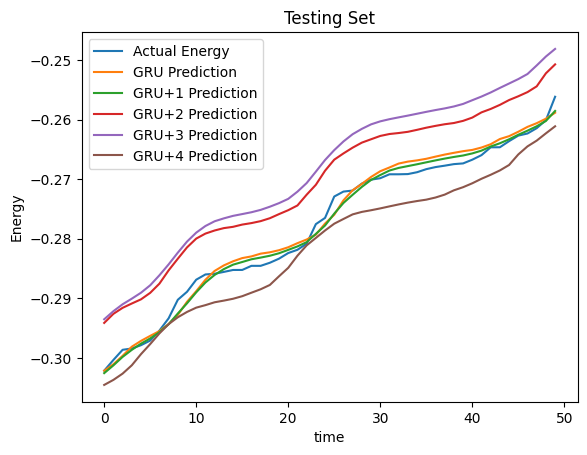

In [49]:
plt.plot(y_test[100:150], label='Actual Energy')
plt.plot(gru_predicted[100:150], label='GRU Prediction')
plt.plot(gru_predicted_1[101:151], label='GRU+1 Prediction')
plt.plot(gru_predicted_2[102:152], label='GRU+2 Prediction')
plt.plot(gru_predicted_3[103:153], label='GRU+3 Prediction')
plt.plot(gru_predicted_4[104:154], label='GRU+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

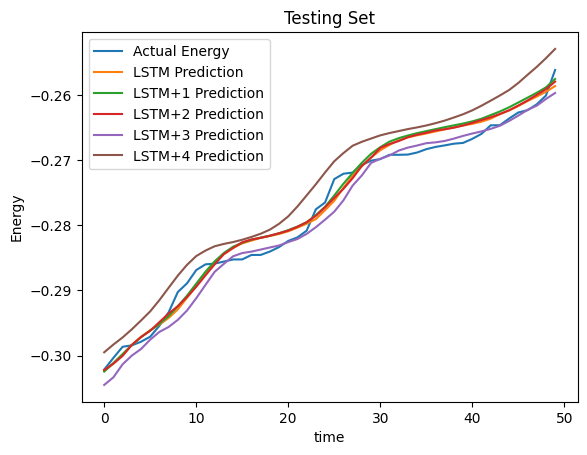

In [50]:
plt.plot(y_test[100:150], label='Actual Energy')
plt.plot(predicted[100:150], label='LSTM Prediction')
plt.plot(predicted_1[101:151], label='LSTM+1 Prediction')
plt.plot(predicted_2[102:152], label='LSTM+2 Prediction')
plt.plot(predicted_3[103:153], label='LSTM+3 Prediction')
plt.plot(predicted_4[104:154], label='LSTM+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

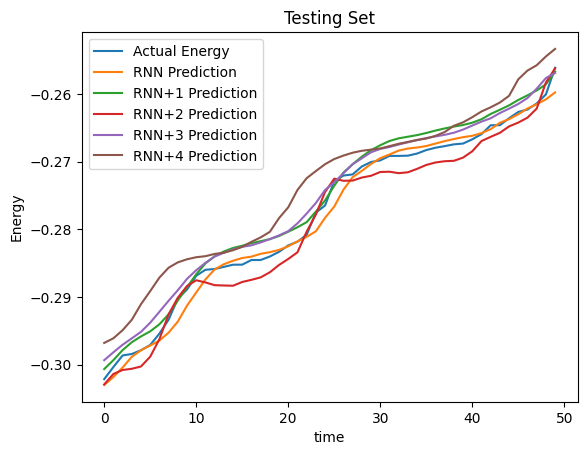

In [51]:
plt.plot(y_test[100:150], label='Actual Energy')
plt.plot(rnn_predicted[100:150], label='RNN Prediction')
plt.plot(rnn_predicted_1[101:151], label='RNN+1 Prediction')
plt.plot(rnn_predicted_2[102:152], label='RNN+2 Prediction')
plt.plot(rnn_predicted_3[103:153], label='RNN+3 Prediction')
plt.plot(rnn_predicted_4[104:154], label='RNN+4 Prediction')
plt.title("Testing Set")
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [94]:
y_test.shape

torch.Size([8820, 1])

In [124]:
# Testing box plot with smaller test dataset
lower_limit = 100
upper_limit = 150

diff_rnn = rnn_predicted[lower_limit:upper_limit] - y_test[lower_limit:upper_limit].numpy()
diff_rnn_1 = rnn_predicted_1[lower_limit+1:upper_limit+1] - y_test[lower_limit:upper_limit].numpy()
diff_rnn_2 = rnn_predicted_2[lower_limit+2:upper_limit+2] - y_test[lower_limit:upper_limit].numpy()
diff_rnn_3 = rnn_predicted_3[lower_limit+3:upper_limit+3] - y_test[lower_limit:upper_limit].numpy()
diff_rnn_4 = rnn_predicted_4[lower_limit+4:upper_limit+4] - y_test[lower_limit:upper_limit].numpy()

diff_gru = gru_predicted[lower_limit:upper_limit] - y_test[lower_limit:upper_limit].numpy()
diff_gru_1 = gru_predicted_1[lower_limit+1:upper_limit+1] - y_test[lower_limit:upper_limit].numpy()
diff_gru_2 = gru_predicted_2[lower_limit+2:upper_limit+2] - y_test[lower_limit:upper_limit].numpy()
diff_gru_3 = gru_predicted_3[lower_limit+3:upper_limit+3] - y_test[lower_limit:upper_limit].numpy()
diff_gru_4 = gru_predicted_4[lower_limit+4:upper_limit+4] - y_test[lower_limit:upper_limit].numpy()

diff_lstm = predicted[lower_limit:upper_limit] - y_test[lower_limit:upper_limit].numpy()
diff_lstm_1 = predicted_1[lower_limit+1:upper_limit+1] - y_test[lower_limit:upper_limit].numpy()
diff_lstm_2 = predicted_2[lower_limit+2:upper_limit+2] - y_test[lower_limit:upper_limit].numpy()
diff_lstm_3 = predicted_3[lower_limit+3:upper_limit+3] - y_test[lower_limit:upper_limit].numpy()
diff_lstm_4 = predicted_4[lower_limit+4:upper_limit+4] - y_test[lower_limit:upper_limit].numpy()

In [125]:
total_diff_rnn = np.concatenate((diff_rnn, diff_rnn_1, diff_rnn_2, diff_rnn_3, diff_rnn_4))
total_diff_gru = np.concatenate((diff_gru, diff_gru_1, diff_gru_2, diff_gru_3, diff_gru_4))
total_diff_lstm = np.concatenate((diff_lstm, diff_lstm_1, diff_lstm_2, diff_lstm_3, diff_lstm_4))

In [126]:
box_data = [total_diff_rnn.squeeze(), total_diff_gru.squeeze(), total_diff_lstm.squeeze()]

In [127]:
total_diff_rnn.squeeze().shape

(250,)

In [128]:
np.random.normal(0, 1, 100).shape

(100,)

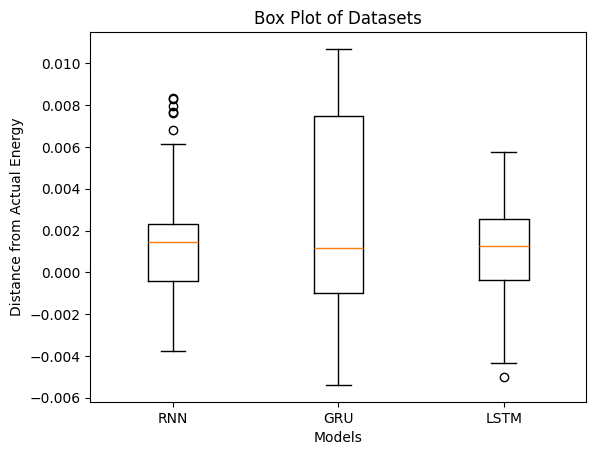

In [129]:
# Create a box plot
plt.boxplot(box_data, labels=['RNN', 'GRU', 'LSTM'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Distance from Actual Energy')
plt.title('Box Plot of Datasets')

# Save the plot
plt.savefig('../figure/box_plot.png')
# Show the plot
plt.show()